In [1]:
# Makes possible to show the output from matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

# Makes the figures in the PNG format:
# For more information see %config InlineBackend
%config InlineBackend.figure_formats=set([u'png'])

# plt.rcParams['figure.figsize'] = 5, 10

import numpy
import sys
import os

import save_load_file as slf

from generates_lsm_start import *

import dtw_python

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# %load generates_lsm_start.py

In [3]:
import matplotlib 

# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

font = {'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

# matplotlib.rcdefaults() # restores to the default values

# http://matplotlib.org/api/matplotlib_configuration_api.html#matplotlib.rc

In [4]:
def distance_cost_plot(distances,xlabel="x",ylabel="y",all_ticks=False,figure=True):
    distances=distances.T
    if figure:
        plt.figure(figsize =(10,10))
    plt.imshow(distances, interpolation='nearest', cmap='Reds') 
    plt.gca().invert_yaxis()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if all_ticks:
        plt.xticks(range(distances.shape[1]),range(distances.shape[1]))
        plt.yticks(range(distances.shape[0]),range(distances.shape[0]))
    plt.grid()
    plt.colorbar();

In [5]:
def path_cost_p(x, y, accumulated_cost, distances):
    
    path = [[len(x)-1, len(y)-1]]
    
    cost = 0
    
    i = len(x)-1
    j = len(y)-1
    
    while i>0 or j>0:
        if i==0:
            j = j - 1
        elif j==0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                i = i - 1
            elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                j = j - 1
            else:
                i = i - 1
                j = j - 1
        path.append([i, j])
    for [x, y] in path:
        cost = cost +distances[x, y]
    return path, cost

In [6]:
def generates_accumulated_cost_p(x,y,distances):
    accumulated_cost = numpy.zeros((len(x), len(y)))
    
    accumulated_cost[0,0] = distances[0,0]
    
    for i in range(1, len(x)):
        accumulated_cost[i,0] = distances[i, 0] + accumulated_cost[i-1, 0]

    for j in range(1, len(y)):
        accumulated_cost[0,j] = distances[0,j] + accumulated_cost[0, j-1]
        
    for i in range(1, len(x)):
        for j in range(1, len(y)):
            accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]
            
    return accumulated_cost

In [7]:
from simulation_2DoF_Arm_physics import *

In [8]:
trajectories = [[[0.75,0.25],[0.0,0.5]],\
                [[0.25,0.60],[-0.25,0.60]],\
                [[-0.10,0.75],[-0.10,0.25]],\
                [[-0.75,0.50],[-0.40,0.00]]]

In [9]:
# First the arm parametres according to Joshi/Maass paper
aparams = {
    'l1' : 0.5, # metres
    'l2' : 0.5,
    'lc1' : 0.25,
    'lc2' : 0.25,
    'm1' : 1.0, # kg
    'm2' : 1.0,
    'i1' : 0.03, # kg*m*m
    'i2' : 0.03
}

In [10]:
# Total time spent during the movement (in seconds)
MT = 0.5
# Simulation time step (in seconds)
time_step = 2/1000.0
# Number of neurons at each input layer (defines the resolution of the system)
Ninput = 50

In [11]:
t_mov=numpy.arange(0, MT, time_step) # t starts in 0s and steps time_step(s) until reaches MT(s)

In [12]:
# Experiment identifier
sim_sets = ["set_A", "set_B", "set_C", "set_D"]

sim_set = sim_sets[2]


total_trials = 50

base_dir = "2DofArm_simulation_data"

In [13]:
# These are the 50 possible values that the input neurons will represent (x,y) 
x_values=numpy.linspace(-1,1,num=50)
y_values=numpy.linspace(-1,1,num=50)

In [19]:
step = 5

tji = 1

noiselevel = 0

decimationlevel = 0

run_number = 1

dtw_total_cost=numpy.zeros((3,3,50),dtype=numpy.float)

x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji,trajectories,x_values,y_values)
H_path=numpy.ascontiguousarray(cartesian_movement_generation_training(xstart, ystart, xdest, ydest, MT, t_mov))

H_path = H_path[::step]

teta = slf.load_from_file("./"+base_dir+"/"+sim_set+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
H,_ = joints_to_hand(teta,aparams)

H = H[::step]

dist_matrix = dtw_python.distances_matrix(H_path,H)


accumulated_cost = dtw_python.accumulated_cost_matrix(H_path,H,dist_matrix)        
path, cost = dtw_python.path_cost_calculation(H_path,H, dist_matrix, accumulated_cost)
dtw_total_cost[noiselevel,decimationlevel,run_number-1] = cost


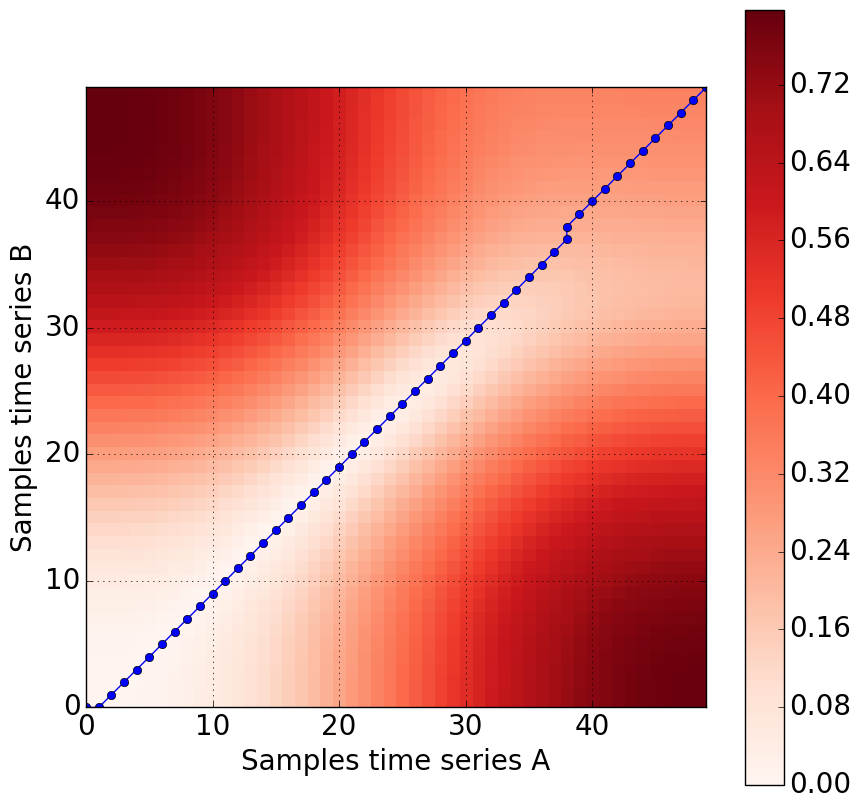

In [20]:
import matplotlib 

# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

font = {'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


plt.figure(figsize =(10,10))


distance_cost_plot(dist_matrix, xlabel="Samples time series A", ylabel="Samples time series B")
plt.plot(path[:,0],path[:,1],'o-')
plt.xlim(0,path[0,0])
plt.ylim(0,path[0,1])
plt.savefig("dtw_example_dist.pdf", bbox_inches='tight',pad_inches=1)
plt.show()

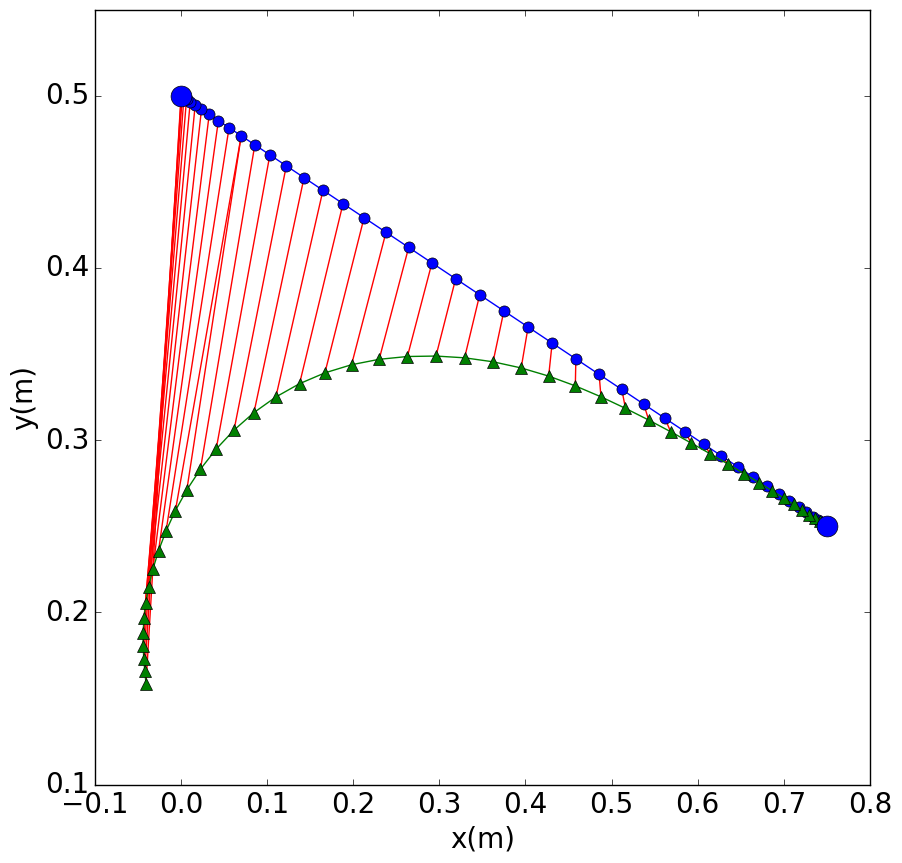

In [71]:
import matplotlib 

# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

font = {'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


plt.figure(figsize =(10,10))

for [map_c, map_e] in path:
    plt.plot([H_path[map_c,0],H[map_e,0]],[H_path[map_c,1],H[map_e,1]] , 'r')

plt.plot(H_path[:,0],H_path[:,1], 'bo-' ,label='original',markersize=8)
plt.plot(H[:,0],H[:,1], 'g^-', label='generated',markersize=8)

plt.plot([xstart,xdest],[ystart,ydest],'o',markersize=15)

plt.xlabel("x(m)")
plt.ylabel("y(m)")

# plt.xlim(-1,1)
plt.ylim(0.1,.55)

plt.savefig("dtw_example.pdf", bbox_inches='tight',pad_inches=1)

plt.show()